In [2]:
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#!pip install catboost
import catboost
from catboost import Pool
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler

%matplotlib inline
sns.set(style="darkgrid")
pd.set_option('display.float_format', lambda x: '%.2f' % x)
warnings.filterwarnings("ignore")

## Loading data

In [3]:
# raw data 로딩 
raw_data = pd.read_csv(r'C:\\Users\\user\\Desktop\\DBC_predict\\intern.csv')
raw_data.head()

,Unnamed: 0,ORD_NO,H_YMD,O_YMD,PKG_GOODS_NO,PKG_GOODS_NM,GOODS_NO,GOODS_NM,STD_GSGR_NO_LEV1_NM,ORD_QTY,CANCEL_QTY,RET_QTY,REAL_ORD_QTY,RECVR_ROAD_BASE_ADDR,SALE_PRICE,DISCOUNT_AMT,FINAL_PRICE
0,0,202201095519105,2022-01-11 00:00:00,2022-01-09 12:26:10,단품,단품,1901012353,수제계란말이(350g),반찬,1,0,0,1,충청북도 증평군 증평읍 송산로 11 (지평더웰아파트),6900,569.00,6331
1,1,202201105522898,2022-01-11 00:00:00,2022-01-10 10:35:49,단품,단품,1901012353,수제계란말이(350g),반찬,1,0,0,1,서울특별시 강남구 논현로85길 52 (역삼동),6900,177.00,6723
2,2,202201115527172,2022-01-12 00:00:00,2022-01-11 11:38:32,단품,단품,1901012353,수제계란말이(350g),반찬,1,0,0,1,"서울특별시 송파구 올림픽로4길 42 (잠실동, 우성아파트)",6900,221.00,6679
3,3,202201105523467,2022-01-12 00:00:00,2022-01-10 13:21:51,단품,단품,1901012353,수제계란말이(350g),반찬,1,0,0,1,강원도 속초시 도리원길 11-14 (노학동),6900,128.00,6772
4,4,202201105522519,2022-01-11 00:00:00,2022-01-10 08:16:21,단품,단품,1901012353,수제계란말이(350g),반찬,1,0,0,1,"경기도 용인시 수지구 동천로 64 (동천동, 동천마을동문굿모닝힐5차아파트)",6900,157.00,6743


In [4]:
# 불필요한 컬럼들 제거
# Unnamed: 단순 데이터 순서를 나타내는 컬럼이기에 삭제
# O_YMD: 주문 시간은 오더 건수와 큰 상관이 없기에 삭제
# ORD_NO: 주문 내용의 일련번호이기에 삭제
# PKG_GOODS_NO: PKG_GOODS_NM과 내용이 겹치고 잘못 적재된 데이터이기에 삭제
# RECVR_ROAD_BASE_ADDR: 비대면으로 주문하는 시대에 지역정보는 큰 의미가 없을 것 같아 삭제
# 등등 미래에 예측할 수 없는 데이터는 모두 삭제

# 카피 데이터 생성
copy_data = raw_data[['H_YMD', 'O_YMD', 'ORD_QTY', 'GOODS_NO', 'CANCEL_QTY', 'RET_QTY', 'SALE_PRICE', 'DISCOUNT_AMT', 'FINAL_PRICE', 'REAL_ORD_QTY']]

# 희망배송일 순서대로 데이터를 정렬
copy_data = copy_data.sort_values(by = 'H_YMD')

### 파이프라인

In [5]:
def ADD_DATETIME(df):
    # 희망배송일의 연도,월,일 데이터를 각각 year, month, day 변수에 넣어준다.

    df['H_YMD'] = pd.to_datetime(df['H_YMD'])
    df['year'] = df['H_YMD'].dt.year
    df['month'] = df['H_YMD'].dt.month
    df['day'] = df['H_YMD'].dt.day

    return df

In [6]:
def ROLLING(df):
    # 몇개의 데이터를 가지고 연산을 할 것인가
    # 데이터들을 순차적으로 6일 (window=6)씩 선택해서 mean처럼 이동평균을 냄
    # 3일치의 min,max,std도 고려할 수 있습니다. 

    # Min value
    f_min = lambda x: x.rolling(window=7).min()
    # Max value
    f_max = lambda x: x.rolling(window=7).max()
    # Mean value
    f_mean = lambda x: x.rolling(window=7).mean()
    # Standard deviation
    f_std = lambda x: x.rolling(window=7).std()

    function_list = [f_min, f_max, f_mean, f_std]
    function_name = ['min', 'max', 'mean', 'std']
    col = ['ORD_QTY', 'CANCEL_QTY', 'RET_QTY', 'SALE_PRICE', 'DISCOUNT_AMT', 'FINAL_PRICE', 'REAL_ORD_QTY']

    for c in col:
        for i in range(len(function_list)):
            #df[('ORD_QTY_shifted_%s' % function_name[i])] = df.sort_values('H_YMD').groupby(['O_YMD', 'GOODS_NO'])['REAL_ORD_QTY'].apply(function_list[i])
            df[('%s_shifted_%s' % (c, function_name[i]))] = df.sort_values('H_YMD').groupby(['GOODS_NO'])[c].apply(function_list[i])
        # Fill the empty std features with 0
        df['%s_shifted_std' % c ].fillna(0, inplace=True)
    
    return df

In [7]:
def LAG(df):
    # 시점을 1일, 2일, 3일로 미뤄서 lag 변수를 생성해준다.

    lag_list = [6,7,8]
    col = ['ORD_QTY', 'CANCEL_QTY', 'RET_QTY', 'SALE_PRICE', 'DISCOUNT_AMT', 'FINAL_PRICE', 'REAL_ORD_QTY']

    for c in col:
        for lag in lag_list:
            ft_name = ('%s_shifted%s' % (c, lag))
            #train_monthly[ft_name] = train_monthly.sort_values('date_block_num').groupby(['GOODS_NO'])['REAL_ORD_QTY'].shift(lag)
            df[ft_name] = df.sort_values('H_YMD').groupby(['GOODS_NO'])[c].shift(lag)
            # Fill the empty shifted features with 0
            df[ft_name].fillna(0, inplace=True)

    return df

In [8]:
def TREND(df):
    # lag 시켰을 때 나온 item_count 판매량을 lag로 나눠서 1을 더해준다.
    lag_list = [6,7,8]
    df['item_trend'] = df['REAL_ORD_QTY_shifted6']

    for lag in lag_list:
        ft_name = ('REAL_ORD_QTY_shifted%s' % lag)
        df['item_trend'] -= df[ft_name]

    df['item_trend'] /= len(lag_list) + 1

    return df

In [9]:
def MEAN_DATA(df):
    
    # 학습데이터의 상품번호 별 일별 판매량 평균
    gp_goods_mean = df.groupby(['H_YMD','GOODS_NO']).agg({'REAL_ORD_QTY_shifted6': ['mean']})
    gp_goods_mean.columns = ['GOODS_mean']
    gp_goods_mean.reset_index(inplace=True)


    # 핛습데이터의 연도별 일별 판매량 평균
    gp_year_mean = df.groupby(['year']).agg({'REAL_ORD_QTY_shifted6': ['mean']})
    gp_year_mean.columns = ['year_mean']
    gp_year_mean.reset_index(inplace=True)

    # 학습데이터의 월별 일별 판매량 평균
    gp_month_mean = df.groupby(['month']).agg({'REAL_ORD_QTY_shifted6': ['mean']})
    gp_month_mean.columns = ['month_mean']
    gp_month_mean.reset_index(inplace=True)

    # 훈련 데이터에 판매량 평균 데이터들 결함
    df = pd.merge(df, gp_goods_mean, on=['H_YMD','GOODS_NO'], how='left')
    df = pd.merge(df, gp_year_mean, on=['year'], how='left')
    df = pd.merge(df, gp_month_mean, on=['month'], how='left')

    return df


In [10]:
# 결측치들을 상품번호별 중앙값으로 대체한다.

def REPLACE_MISSING_VALUE(df):
    #Replace missing values with the median of each shop.            
    for goods_no in df['GOODS_NO'].unique():
        #print('goods_no: ', goods_no)
        for column in df.columns:
            goods_median = df[(df['GOODS_NO'] == goods_no)][column].median()
            df.loc[(df[column].isnull()) & (df['GOODS_NO'] == goods_no), column] = goods_median

    # Fill remaining missing values on test set with mean.
    df.fillna(df.mean(), inplace=True)


    return df 

In [11]:
def DBC_PIPELINE(df):
    temp = df.copy()
    
    temp = ADD_DATETIME(temp)
    
    temp = ROLLING(temp)
    
    temp = LAG(temp)

    temp = TREND(temp)

    temp = MEAN_DATA(temp)

    temp = REPLACE_MISSING_VALUE(temp)

    return temp

### 데이터 분할

In [12]:
my_data= copy_data.copy()

my_data = my_data[my_data['H_YMD'] > '2020-01-05']

my_data.head()

,H_YMD,O_YMD,ORD_QTY,GOODS_NO,CANCEL_QTY,RET_QTY,SALE_PRICE,DISCOUNT_AMT,FINAL_PRICE,REAL_ORD_QTY
168675,2020-01-06 00:00:00,2020-01-05 00:14:21,1,3273,0,0,4200,NaN,4200,1
167277,2020-01-06 00:00:00,2020-01-03 13:26:34,1,1712010310,0,0,6900,403.00,6497,1
174692,2020-01-06 00:00:00,2020-01-04 13:16:36,2,1808011751,0,0,8900,561.00,8339,2
167464,2020-01-06 00:00:00,2020-01-03 16:52:49,1,1805011121,0,0,5800,NaN,5800,1
171755,2020-01-06 00:00:00,2020-01-03 17:33:06,1,1808011751,0,0,8900,NaN,8900,1


In [13]:
# 데이터를 H_YMD(희망배송일), GOODS_NO(상품 번호)로 groupby를 해준다.
# SALE_PRICE(판매가격), ORD_QTY(주문 건수), REAL_ORD_QTY(최종주문건수)의 평균값과 매매거래량 변수를 만든다.

my_data['O_YMD'] = pd.to_datetime(my_data['O_YMD'])
my_data['O_YMD'] = my_data['O_YMD'].dt.weekday

my_data = my_data.groupby(['H_YMD', 'GOODS_NO'], as_index=False)
my_data = my_data.agg({
                        'SALE_PRICE':['sum'], 
                        'ORD_QTY':['sum'],
                        'REAL_ORD_QTY':['sum'],
                        'CANCEL_QTY':['sum'],
                        'RET_QTY':['sum'],
                        'DISCOUNT_AMT':['sum'],
                        'FINAL_PRICE':['sum']
                        })

my_data.columns = [
                    'H_YMD', 'GOODS_NO',
                    'SALE_PRICE',
                    'ORD_QTY',
                    'REAL_ORD_QTY',
                    'CANCEL_QTY',
                    'RET_QTY',
                    'DISCOUNT_AMT',
                    'FINAL_PRICE'
                    ]

my_data.head()

,H_YMD,GOODS_NO,SALE_PRICE,ORD_QTY,REAL_ORD_QTY,CANCEL_QTY,RET_QTY,DISCOUNT_AMT,FINAL_PRICE
0,2020-01-06 00:00:00,1823,125400,39,38,1,0,2300.00,123100
1,2020-01-06 00:00:00,3273,180600,47,45,2,0,4906.00,175694
2,2020-01-06 00:00:00,4092,92000,23,19,4,0,2146.00,89854
3,2020-01-06 00:00:00,13957,293600,62,55,7,0,5400.00,288200
4,2020-01-06 00:00:00,14375,911600,119,112,7,0,15848.00,895752


In [589]:
time_data = my_data[['H_YMD', 'REAL_ORD_QTY']]

time_data['H_YMD'] = pd.to_datetime(time_data['H_YMD'])

time_data = time_data.groupby('H_YMD').agg({'REAL_ORD_QTY':['sum']})

time_data.columns = ['REAL_ORD_QTY']
#time_data.set_index('H_YMD', inplace=True)

time_data.head()

,REAL_ORD_QTY
H_YMD,
2020-01-06,621
2020-01-07,755
2020-01-08,708
2020-01-09,635
2020-01-10,614


In [14]:
my_data =  DBC_PIPELINE(my_data)

In [15]:
my_data.to_csv('C:\\Users\\user\\Desktop\\my_data.csv', encoding='utf-8-sig')

In [16]:
from sklearn.model_selection import train_test_split

my_data['H_YMD'] = pd.to_datetime(my_data['H_YMD'])

test_set =my_data[(my_data['H_YMD'].dt.year == 2022) & (my_data['H_YMD'].dt.month == 5)] # 2022년 5월 데이터를 테스트셋으로 설정

idx = my_data[(my_data['H_YMD'].dt.year == 2022) & (my_data['H_YMD'].dt.month == 5)].index # 2022년 5월 데이터의 인덱스 저장
my_data.drop(idx, inplace=True)

target = 'REAL_ORD_QTY'

Y = my_data[target]
X = my_data.drop(target, axis=1)

X_train, X_val, y_train, y_val = train_test_split(X,Y, test_size=.2, shuffle=False, random_state=2022 )
y_test = test_set[target]
X_test = test_set.drop(target, axis=1)


In [17]:
X_train = X_train[(X_train['H_YMD'] > '2020-01-11')& (X_train['H_YMD'] < '2022-05-01')]
y_train = y_train[len(y_train)-len(X_train):]

In [18]:
X_train.columns

Index(['H_YMD', 'GOODS_NO', 'SALE_PRICE', 'ORD_QTY', 'CANCEL_QTY', 'RET_QTY',
       'DISCOUNT_AMT', 'FINAL_PRICE', 'year', 'month', 'day',
       'ORD_QTY_shifted_min', 'ORD_QTY_shifted_max', 'ORD_QTY_shifted_mean',
       'ORD_QTY_shifted_std', 'CANCEL_QTY_shifted_min',
       'CANCEL_QTY_shifted_max', 'CANCEL_QTY_shifted_mean',
       'CANCEL_QTY_shifted_std', 'RET_QTY_shifted_min', 'RET_QTY_shifted_max',
       'RET_QTY_shifted_mean', 'RET_QTY_shifted_std', 'SALE_PRICE_shifted_min',
       'SALE_PRICE_shifted_max', 'SALE_PRICE_shifted_mean',
       'SALE_PRICE_shifted_std', 'DISCOUNT_AMT_shifted_min',
       'DISCOUNT_AMT_shifted_max', 'DISCOUNT_AMT_shifted_mean',
       'DISCOUNT_AMT_shifted_std', 'FINAL_PRICE_shifted_min',
       'FINAL_PRICE_shifted_max', 'FINAL_PRICE_shifted_mean',
       'FINAL_PRICE_shifted_std', 'REAL_ORD_QTY_shifted_min',
       'REAL_ORD_QTY_shifted_max', 'REAL_ORD_QTY_shifted_mean',
       'REAL_ORD_QTY_shifted_std', 'ORD_QTY_shifted6', 'ORD_QTY_shifted7'

In [19]:
features = [
            'ORD_QTY_shifted_min', 'ORD_QTY_shifted_max', 'ORD_QTY_shifted_mean',
            'CANCEL_QTY_shifted_max',  'REAL_ORD_QTY_shifted_min',
            'REAL_ORD_QTY_shifted_mean',
            'ORD_QTY_shifted8', 'CANCEL_QTY_shifted6', 'CANCEL_QTY_shifted7',
            'REAL_ORD_QTY_shifted7', 'REAL_ORD_QTY_shifted8', 
            'GOODS_mean', 'month_mean'
            ]


# 모델링

In [20]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline, make_pipeline

In [21]:
X_train = X_train[features]
X_val = X_val[features]
X_test = X_test[features]

In [22]:
X_train_l = np.log1p(X_train)
X_val_l = np.log1p(X_val)
X_test_l = np.log1p(X_test)

y_train = np.log1p(y_train)
y_val = np.log1p(y_val)
y_test = np.log1p(y_test)

In [39]:
def evaluate_regr(y, pred):
    mse = mean_squared_error(y, pred)
    rmse_val = np.sqrt(mse)
    mae_val = mean_absolute_error(y, pred)
    r2 = r2_score(y, pred)
    print('RMSE : {} | MAE : {} | r2 : {} '.format(round(rmse_val,5),round(mae_val,5),round(r2,5)))

# 여러 모델의 성능 확인 함수 
def get_model_predict(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)

    print('###', model.__class__.__name__,'###')
    evaluate_regr(y_test, pred)
#--------------------------------------------------------------------
#모델별로 평가 확인 

ridge_reg = Ridge(alpha=0)      # best alpha = 0
lasso_reg = Lasso(alpha=1)        # best alpha = 1
tree_reg = DecisionTreeRegressor(random_state=13)
xgb_reg = XGBRegressor(n_estimators=1000, random_state=13)
forest_reg = RandomForestRegressor(n_estimators=100,random_state=13)
lgbm_reg = LGBMRegressor(n_estimators=500, objective='regression')

for model in [ridge_reg, lasso_reg, tree_reg, xgb_reg, forest_reg, lgbm_reg]:
# for model in [forest_reg]:
    #get_model_predict(model, X_train, X_val, y_train, y_val)
    get_model_predict(model, X_train_l, X_val_l, y_train, y_val)

### Ridge ###
RMSE : 0.37481 | MAE : 0.26536 | r2 : 0.77985 
### Lasso ###
RMSE : 0.79896 | MAE : 0.62325 | r2 : -0.00033 
### DecisionTreeRegressor ###
RMSE : 0.54884 | MAE : 0.3611 | r2 : 0.52795 
### XGBRegressor ###
RMSE : 0.44801 | MAE : 0.30332 | r2 : 0.68547 
### RandomForestRegressor ###
RMSE : 0.39477 | MAE : 0.2721 | r2 : 0.75578 
### LGBMRegressor ###
RMSE : 0.40487 | MAE : 0.28361 | r2 : 0.74313 


In [24]:
pd.DataFrame([X_train.columns, ridge_reg.coef_]).T

,0,1
0,ORD_QTY_shifted_min,-0.08
1,ORD_QTY_shifted_max,0.08
2,ORD_QTY_shifted_mean,-1.08
3,CANCEL_QTY_shifted_max,0.02
4,REAL_ORD_QTY_shifted_min,0.36
5,REAL_ORD_QTY_shifted_mean,1.85
6,ORD_QTY_shifted8,0.37
7,CANCEL_QTY_shifted6,0.02
8,CANCEL_QTY_shifted7,-0.00
9,REAL_ORD_QTY_shifted7,-0.06


## 릿지 하이퍼 파라미터 튜닝

In [32]:
ridge_reg = Ridge()
pipe = make_pipeline(MinMaxScaler(), ridge_reg)
scores = cross_validate(pipe, X_train, y_train, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
print('ridge MSLE: {0:.3f}'.format(np.mean(-scores['test_score'])))

ridge MSLE: 0.233


In [31]:
red_pipeline = Pipeline([('scaler', MinMaxScaler()), ('ridge', Ridge())])
red_params = {'ridge__alpha':[5, 10, 15, 20]}
red_grid_model = GridSearchCV(red_pipeline, param_grid=red_params, scoring='neg_mean_squared_error', cv=5)
red_grid_model.fit(X_train, y_train)
print('MLSE: {0:.3f}'.format( -1*red_grid_model.best_score_))
print('optimal hyperparameter: ',  red_grid_model.best_params_)

MLSE: 0.234
optimal hyperparameter:  {'ridge__alpha': 5}


In [46]:
ridge_reg = Ridge()
ridge_reg.fit(X_train_l, y_train)
red_pred = ridge_reg.predict(X_val_l)
print('r2: ', r2_score(np.expm1(y_val), np.expm1(red_pred)))

r2:  0.7701429930230316


## 랜덤 포레스트 튜닝

In [33]:
np.random.seed(0)
rf = RandomForestRegressor(n_estimators=500)
pipe = make_pipeline(MinMaxScaler(), rf)
scores =  cross_validate(pipe, X_train, y_train, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
print('rf MSLE: {0:.3f}'.format(np.mean(-scores['test_score'])))

rf MSLE: 0.130


In [26]:
rf_pipeline = Pipeline([('sclaer', MinMaxScaler()), ('rf', RandomForestRegressor())])
rf_params = {'rf__max_depth': [5, 10 , None],
             'rf__min_samples_leaf': [1, 3],
             'rf__min_samples_split':[2, 3],
             'rf__n_estimators':[500, 1000]}
rf_grid_model = GridSearchCV(rf_pipeline, param_grid=rf_params, scoring='neg_mean_squared_error', cv=5,
                            n_jobs=5, verbose=True)
rf_grid_model.fit(X_train, y_train)
print('rf MLSE: {0:.3f}'.format( -1*rf_grid_model.best_score_))
print('rf optimal hyperparameter: ',  rf_grid_model.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
rf MLSE: 0.126
rf optimal hyperparameter:  {'rf__max_depth': 10, 'rf__min_samples_leaf': 3, 'rf__min_samples_split': 2, 'rf__n_estimators': 1000}


In [50]:
# rf_model = RandomForestRegressor(max_depth=10,
#                                  min_samples_leaf=3,
#                                  min_samples_split=2,
#                                  n_estimators=1000
#                                  )
rf_model = RandomForestRegressor(n_estimators=500)
rf_model.fit(X_train_l, y_train)
rf_pred = rf_model.predict(X_val_l)
print('r2: ', r2_score(np.expm1(y_val), np.expm1(rf_pred)))


r2:  0.7527376647850436


## LGBM 하이퍼 파리미터 튜닝

In [34]:
lgbm = LGBMRegressor(n_estimators=500, objective='regression')
pipe = make_pipeline(MinMaxScaler(), rf)
scores =  cross_validate(pipe, X_train, y_train, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
print('lgbm MSLE: {0:.3f}'.format(np.mean(-scores['test_score'])))

lgbm MSLE: 0.130


In [36]:
lgbm_pipeline = Pipeline([('scaler', MinMaxScaler()), ('lgbm', LGBMRegressor(objective='regression'))])
lgbm_params = {'lgbm__learning_rate':[0.001, 0.01, 0.1],
               'lgbm__max_depth': [5, 10],
               'lgbm__reg_lambda':[0.1, 1],
               'lgbm__subsample': [0.5, 1],
               'lgbm__n_estimators': [500, 1000]}
lgbm_grid_model = GridSearchCV(lgbm_pipeline, param_grid=lgbm_params, scoring='neg_mean_squared_error',
                               cv=5, n_jobs=5, verbose=True)
lgbm_grid_model.fit(X_train, y_train)
print('lgbm MLSE: {0:.3f}'.format( -1*lgbm_grid_model.best_score_))
print('lgbm optimal hyperparameter: ',  lgbm_grid_model.best_params_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
lgbm MLSE: 0.128
lgbm optimal hyperparameter:  {'lgbm__learning_rate': 0.01, 'lgbm__max_depth': 5, 'lgbm__n_estimators': 1000, 'lgbm__reg_lambda': 0.1, 'lgbm__subsample': 0.5}


In [55]:
scaler = MinMaxScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s = scaler.transform(X_val)
X_test_s = scaler.transform(X_test)

In [52]:
lgbm_model = LGBMRegressor(learning_rate=0.01,
                           max_depth=5,
                           n_estimators=1000,
                           reg_lambda=0.1,
                           subsample=0.5)
lgbm_model.fit(X_train_l, y_train)
lgbm_pred = lgbm_model.predict(X_test_l)
print('r2: ', r2_score(np.expm1(y_test), np.expm1(lgbm_pred)))

r2:  0.8116026295147978


In [56]:
lgbm_model = LGBMRegressor(learning_rate=0.01,
                           max_depth=5,
                           n_estimators=1000,
                           reg_lambda=0.1,
                           subsample=0.5)
lgbm_model.fit(X_train_s, y_train)
lgbm_pred = lgbm_model.predict(X_test_s)
print('r2: ', r2_score(y_test, lgbm_pred))

r2:  0.7104007002859771


In [54]:
np.expm1(y_test)

10390    65.00
10391   107.00
10392    53.00
10393    93.00
10394   141.00
         ...  
10877    22.00
10878    33.00
10879    54.00
10880    38.00
10881    55.00
Name: REAL_ORD_QTY, Length: 492, dtype: float64

In [53]:
np.expm1(lgbm_pred)

array([ 67.94624182,  83.78408402,  53.66634771,  88.04666286,
       142.37942615,  57.59107303, 215.76810311,  45.70412525,
        19.74276955,  55.24287478,  50.06886747,  44.50556261,
        29.00507928,  19.93317744,  21.33423595,  54.41761643,
        27.80175604,  65.69524557,  60.52195717,  77.33879708,
        51.90590106,  88.00074452, 138.17062275,  55.20317419,
       225.0456031 ,  47.14349914,  20.21498434,  57.78452858,
        46.22578497,  41.92058034,  28.22253514,  19.4126323 ,
        19.06346239,  54.89211525,  30.26882479,  65.68198106,
        57.30768965,  70.4099635 ,  48.16993418,  86.36605666,
       153.6102349 ,  56.50635157, 226.15954355,  48.59365859,
        18.99195188,  54.73030668,  40.30425064,  34.82476629,
        30.67800652,  20.80387985,  18.04779317,  56.74800696,
        30.97413027,  66.22080403,  50.73901079,  52.05635652,
        45.7709004 ,  67.1798825 , 120.01060434,  58.73598541,
       225.31246379,  45.07643533,  19.17661901,  43.96

## BEST MODEL

In [505]:
xgb_model = XGBRegressor(max_depth=5, 
                         n_estimators=1000, 
                         min_child_weight=1000,  
                         colsample_bytree=0.7, 
                         subsample=0.7, 
                         eta=0.01, 
                         seed=0)
xgb_model.fit(X_train_l, 
              y_train, 
              eval_metric="rmse", 
              eval_set=[(X_train_l, y_train), (X_val_l, y_val)], 
              verbose=30, 
              early_stopping_rounds=20)

[0]	validation_0-rmse:3.53033	validation_1-rmse:3.52349
[30]	validation_0-rmse:2.62870	validation_1-rmse:2.61559
[60]	validation_0-rmse:1.96589	validation_1-rmse:1.95284
[90]	validation_0-rmse:1.48114	validation_1-rmse:1.46937
[120]	validation_0-rmse:1.13025	validation_1-rmse:1.12107
[150]	validation_0-rmse:0.88020	validation_1-rmse:0.87360
[180]	validation_0-rmse:0.70626	validation_1-rmse:0.70152
[210]	validation_0-rmse:0.58948	validation_1-rmse:0.58700
[240]	validation_0-rmse:0.51396	validation_1-rmse:0.51376
[270]	validation_0-rmse:0.46685	validation_1-rmse:0.46860
[300]	validation_0-rmse:0.43858	validation_1-rmse:0.44244
[330]	validation_0-rmse:0.42191	validation_1-rmse:0.42742
[360]	validation_0-rmse:0.41206	validation_1-rmse:0.41876
[390]	validation_0-rmse:0.40615	validation_1-rmse:0.41383
[420]	validation_0-rmse:0.40265	validation_1-rmse:0.41115
[450]	validation_0-rmse:0.40049	validation_1-rmse:0.40955
[480]	validation_0-rmse:0.39908	validation_1-rmse:0.40862
[510]	validation_0-

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
             early_stopping_rounds=None, enable_categorical=False, eta=0.01,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.00999999978, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1000,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, ...)

In [261]:
import joblib

joblib.dump(xgb_model, 'xgb_model.pkl')

['xgb_model.pkl']

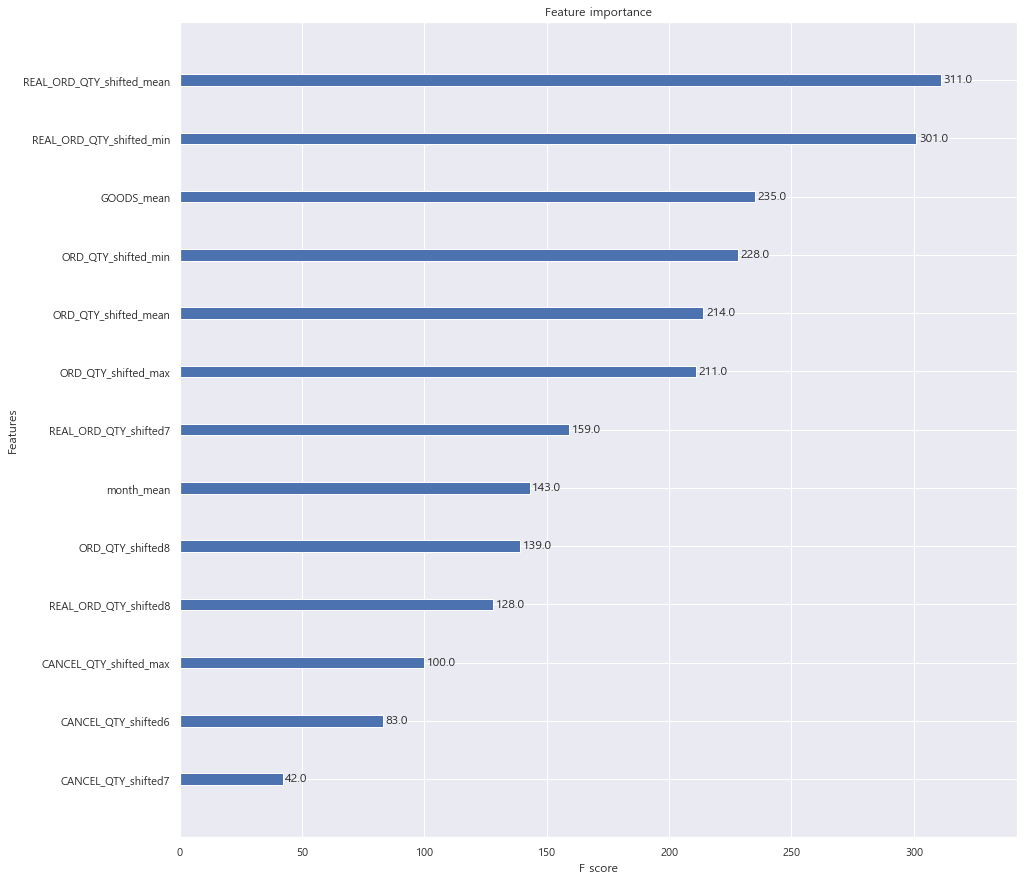

In [514]:
plt.rcParams["figure.figsize"] = (15, 15)
plot_importance(xgb_model)
plt.show()

In [507]:
xgb_train_pred = xgb_model.predict(X_train_l)
xgb_val_pred = xgb_model.predict(X_val_l)
xgb_test_pred = xgb_model.predict(X_test_l)

In [508]:
xgb_test_pred = np.expm1(xgb_test_pred)
y_test = np.expm1(y_test)

In [509]:
from sklearn.metrics import r2_score

print('r2:', r2_score(y_test, xgb_test_pred))
print('Train rmse:', np.sqrt(mean_squared_error(y_train, xgb_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(y_val, xgb_val_pred)))

r2: 0.7227666267368705
Train rmse: 0.3961672448035988
Validation rmse: 0.4076341965828235


In [221]:
# 자재코드와 자재명을 딕셔너리 형태로 만들기
GOODS_DIC = {1712010310 : '두메산나물비빔밥재료', 14375:	'옛날잡채(500g)', 3273:'채소계란찜(340g)', 13957:'셀프두부조림(600g)', 1901012353:'수제계란말이(350g)',
             13529:'메밀소바(2인분)', 1803010879:'고소한도토리묵무침(360g)', 2012014895:'한돈 제육볶음(700g)', 2204016772:'소고기유니짜장소스(1인분, 200g)', 
             1823:'숙주나물(300g)', 4092:'건표고버섯볶음', 14985:'양장피', 1808011751:'꼬막무침 (260g)', 1903012675:'순살코다리강정(180g)', 
             2010014667:'우삼겹숙주볶음(250g)', 1806011271:'열무비빔밥재료믹스(2인분)', 2103015231:'[심방골주부X더반찬] 시골 돼지짜글이(600g)', 
             2010014707:'고구마 품은 라자냐(450g)', 1805011121:'고사리나물볶음(150g)', 1909013359:'가정집 오징어불고기/셀프(380g)'
             }

In [405]:
def to_csv(predict, x_test, y_test):
    
    x_test.reset_index(drop=True, inplace=True)
    predict = pd.DataFrame(predict)
    predict['H_YMD'] = x_test['H_YMD']
    predict['GOODS_NO'] = x_test['GOODS_NO']
    
    y_test = pd.DataFrame(y_test)
    y_test.reset_index(drop=True, inplace=True)
    y_test['H_YMD'] = x_test['H_YMD']
    y_test['GOODS_NO'] = x_test['GOODS_NO']
    
    for n in GOODS_DIC.keys():
        predict['GOODS_NO'].loc[predict['GOODS_NO'] == n ] = GOODS_DIC[n]
        y_test['GOODS_NO'].loc[y_test['GOODS_NO'] == n ] = GOODS_DIC[n]

    
    predict.columns = ['REAL_ORD_QTY',  'H_YMD', 'GOODS_NM']
    y_test.columns = ['REAL_ORD_QTY',  'H_YMD', 'GOODS_NM']

    predict = predict.groupby(['H_YMD', 'GOODS_NM'])
    predict = predict.sum()

    y_test = y_test.groupby(['H_YMD','GOODS_NM'])
    y_test = y_test.sum()

    return predict, y_test

In [406]:
xgb_result, y_result = to_csv(xgb_test_pred, X_test, y_test)

y_result.to_csv('C:\\Users\\user\\Desktop\\y_result.csv', encoding='utf-8-sig')
xgb_result.to_csv('C:\\Users\\user\\Desktop\\xgb_result.csv', encoding='utf-8-sig')


In [407]:
y_result

REAL_ORD_QTY
H_YMD      GOODS_NM                                
2022-05-02 [심방골주부X더반찬] 시골 돼지짜글이(600g)         35.00
           가정집 오징어불고기/셀프(380g)                35.00
           건표고버섯볶음                            53.00
           고구마 품은 라자냐(450g)                    9.00
           고사리나물볶음(150g)                      25.00
...                                             ...
2022-05-31 열무비빔밥재료믹스(2인분)                     53.00
           옛날잡채(500g)                        108.00
           우삼겹숙주볶음(250g)                      22.00
           채소계란찜(340g)                        83.00
           한돈 제육볶음(700g)                      54.00

[492 rows x 1 columns]

In [409]:
xgb_result.reset_index()

,H_YMD,GOODS_NM,REAL_ORD_QTY
0,2022-05-02,[심방골주부X더반찬] 시골 돼지짜글이(600g),24.95
1,2022-05-02,가정집 오징어불고기/셀프(380g),29.94
2,2022-05-02,건표고버섯볶음,51.25
3,2022-05-02,고구마 품은 라자냐(450g),20.80
4,2022-05-02,고사리나물볶음(150g),20.72
...,...,...,...
487,2022-05-31,열무비빔밥재료믹스(2인분),42.18
488,2022-05-31,옛날잡채(500g),98.23
489,2022-05-31,우삼겹숙주볶음(250g),20.41
490,2022-05-31,채소계란찜(340g),50.92
